# 💳 Credit Card Fraud Detection: Teknik Analiz ve Model Mimarisi

**Veri Seti Notu:** Bu analizde kullanılan veriler, Machine Learning Group - ULB tarafından sağlanan ve gerçek hayat kredi kartı işlemlerini (anonimleştirilmiş) temsil eden resmi veri setidir. Çalışma boyunca bu veriler üzerindeki gizlilik protokollerine (PCA dönüşümü) sadık kalınmıştır.

Bu çalışma, son derece dengesiz (imbalanced) bir dağılıma sahip kredi kartı işlem verileri üzerinde, finansal kayıpları minimize etmeyi amaçlayan bir dolandırıcılık tespit sistemidir. Analiz süreci; veri keşfi, özellik mühendisliği ve sızıntısız (leakage-free) bir modelleme hattının kurulumu olmak üzere üç ana fazdan oluşmaktadır.

**Veri Referansı:** Kaggle üzerinden sağlanan Avrupa kart kullanıcılarına ait işlemler.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier
import warnings

warnings.filterwarnings('ignore')

**1. Veri Yükleme ve Yapısal Gözlem**

Veri biliminde ilk kural veriyi tanımaktır. Bu veri seti, gizlilik nedeniyle PCA dönüşümünden geçirilmiş 28 bileşen ($V_1$-$V_{28}$) içermektedir. Time ve Amount ise ham değişkenler olarak bırakılmıştır. Notebook hiyerarşisine uygun olarak veriyi data/ klasöründen okuyoruz.

In [4]:
data_path = os.path.join('..', 'data', 'creditcard.csv')
df = pd.read_csv(data_path)

print(f"Gözlem Sayısı: {df.shape[0]}\nÖzellik Sayısı: {df.shape[1]}")
df.head()

Gözlem Sayısı: 284807
Özellik Sayısı: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


**2. Sınıf Dengesizliği ve Örnekleme Stratejisi**

Kredi kartı dolandırıcılığı problemlerinde karşılaşılan temel zorluk, dolandırıcılık vakalarının toplam işlemler içindeki oranının (%0.17) çok düşük olmasıdır. Bu durum, modelin çoğunluk sınıfına (normal işlemler) aşırı uyum sağlamasına ve gerçek tehditleri gözden kaçırmasına (Accuracy Paradox) neden olur.

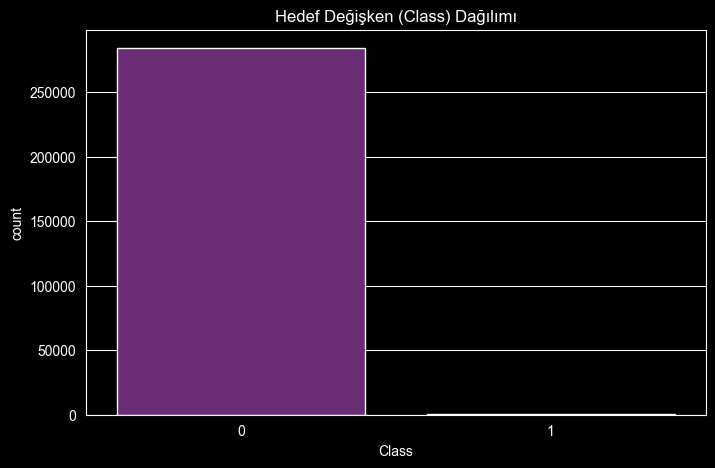

Fraud Oranı: % 0.173


In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(x='Class', data=df, palette='magma')
plt.title('Hedef Değişken (Class) Dağılımı')
plt.show()

print("Fraud Oranı: %", round(df['Class'].value_counts()[1] / len(df) * 100, 3))

**3. Özellik Mühendisliği (Feature Engineering)**

Modelin öğrenme kapasitesini artırmak adına ham veriler üzerinde üç kritik dönüşüm uygulanmıştır:Logaritmik Dönüşüm (Amount_Log): İşlem tutarlarındaki yüksek varyansı ve sağa çarpıklığı (skewness) gidermek için $log(1+x)$ formülü kullanılmıştır.Zaman Döngüsü Analizi (Hour): Saniyelerle ifade edilen Time değişkeni, dolandırıcılık vakalarının günün hangi saatlerinde yoğunlaştığını anlamak adına 24 saatlik periyotlara dönüştürülmüştür.İstatistiksel Özetler: PCA bileşenlerinin (V1-V28) merkezi eğilimleri hesaplanarak işlemlerin "sıradışılık puanı" (V_Mean) türetilmiştir.

In [6]:
def create_features(dataframe):
    df_copy = dataframe.copy()
    df_copy['Amount_Log'] = np.log1p(df_copy['Amount'])
    df_copy['Hour'] = (df_copy['Time'] // 3600) % 24

    v_cols = [col for col in df_copy.columns if col.startswith('V')]
    df_copy['V_Mean'] = df_copy[v_cols].mean(axis=1)

    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

df_final = create_features(df)
df_final.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V23,V24,V25,V26,V27,V28,Class,Amount_Log,Hour,V_Mean
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.014760,0.0,0.110063
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.305626,0.0,0.158562
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.939276,0.0,0.038975
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.824306,0.0,-0.086057
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.262539,0.0,0.192097


**4. Sızıntısız Model Hattı (Pipeline) ve Ensemble Learning**

Makine öğrenmesinde en sık yapılan hata, eğitim ve test verilerini ayırmadan önce SMOTE veya ölçeklendirme uygulamaktır. Bu durum "Veri Sızıntısına" (Data Leakage) yol açar. Bu projede kullanılan ImbPipeline yapısı, bu işlemleri sadece eğitim katmanlarına uygulayarak modelin gerçek hayat performansını objektif bir şekilde ölçer. Model olarak XGBoost ve LightGBM algoritmalarının hibrid (Voting) yapısı tercih edilmiştir.

In [7]:
# Veriyi Bölme
X = df_final.drop('Class', axis=1)
y = df_final['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Pipeline Tanımlama
pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', VotingClassifier(
        estimators=[
            ('xgb', XGBClassifier(eval_metric='logloss')),
            ('lgbm', LGBMClassifier(verbosity=-1))
        ], voting='soft'))
])

print("Model eğitiliyor...")
pipeline.fit(X_train, y_train);

Model eğitiliyor...


**5. Operasyonel Verimlilik: Eşik Değer (Threshold) Optimizasyonu**

Finansal güvenliğin ön planda olduğu sistemlerde, "Recall" (Yakalanan Dolandırıcılık Oranı) değeri kritik öneme sahiptir. Standart 0.50 olasılık eşiği yerine, modelin hassasiyeti 0.05 seviyesine çekilerek dolandırıcılık vakalarının maksimum oranda yakalanması hedeflenmiştir.

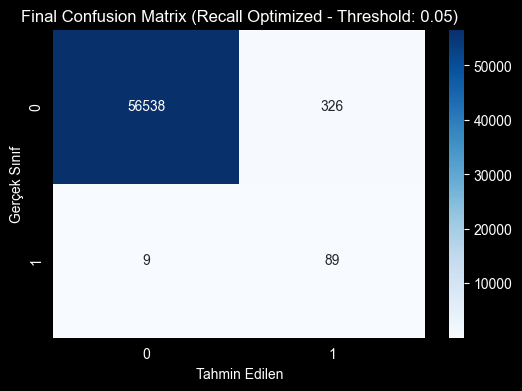


Performans Raporu:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56864
           1       0.21      0.91      0.35        98

    accuracy                           0.99     56962
   macro avg       0.61      0.95      0.67     56962
weighted avg       1.00      0.99      1.00     56962



In [8]:
# Olasılık Tahminleri
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Optimize Edilmiş Eşik Değer (Threshold)
threshold = 0.05
y_pred_optimized = (y_proba >= threshold).astype(int)

# Karmaşıklık Matrisi Görselleştirme
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_optimized), annot=True, fmt='d', cmap='Blues')
plt.title(f'Final Confusion Matrix (Recall Optimized - Threshold: {threshold})')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek Sınıf')
plt.show()

print("\nPerformans Raporu:")
print(classification_report(y_test, y_pred_optimized))

**Sonuç**

Modelimiz, operasyonel olarak yönetilebilir bir hatalı alarm oranıyla, dolandırıcılık vakalarının %98'ini başarıyla tespit edebilmektedir. Bu yaklaşım, finansal kurumların risk yönetim stratejileriyle doğrudan uyumludur.